In [1]:
import sys
  
# setting path
sys.path.append('../')

In [2]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import IPython.display
from pydub import AudioSegment

from utils.audio import Audio
from utils.hparams import HParam

import torch
import torch.nn as nn

from utils.power_law_loss import PowerLawCompLoss
from model.model import VoiceFilter
from model.embedder import SpeechEmbedder
from mir_eval.separation import bss_eval_sources

In [3]:
hp = HParam("../config.yaml")

../utils/hparams.py:18: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for doc in docs:


# Preparation

In [4]:
def getaudio(sample, base_fix="../"):
    sr = hp.audio.sample_rate
    s1_dvec = base_fix+sample["embedding_utterance_path"]
    s1_target = base_fix+sample["clean_utterance_path"]
    s2 = base_fix+sample["interference_utterance_path"]
    l1 = sample["clean_segment"]
    l2 = sample["interference_segment"]
    audio_len = sample["segment_length"]*sr

    d, _ = librosa.load(s1_dvec, sr=sr)
    w1, _ = librosa.load(s1_target, sr=sr)
    w2, _ = librosa.load(s2, sr=sr)

    d, _ = librosa.effects.trim(d, top_db=20)
    w1, _ = librosa.effects.trim(w1, top_db=20)
    w2, _ = librosa.effects.trim(w2, top_db=20)

    # Mix 2 audio, then trim to match clean audio length
    w1, w2 = w1[l1:l1+audio_len], w2[l2:l2+audio_len]
    mixed = w1 + w2

    norm = np.max(np.abs(mixed)) * 1.1
    w1, w2, mixed = w1/norm, w2/norm, mixed/norm
    
    return d, w1, mixed, w2

In [5]:
vn_dataset_df = pd.read_csv("VNGenerateDataset.csv")
lb_dataset_df = pd.read_csv("LibriSpeechGenerateDataset.csv")

In [6]:
with open("VNGenerate_test.json", "r") as f:
    vn_test_result = json.load(f)

for key in list(vn_test_result.keys()):
    vn_test_result[key] = np.array(vn_test_result[key])
    if "losses" in key:
        vn_test_result[key] = np.mean(vn_test_result[key])
    else:
        vn_dataset_df[key] = vn_test_result[key]
        if "sdrs" in key and "before" not in key and "improve" not in key:
            vn_dataset_df[key+"_improve"] = vn_dataset_df[key] - vn_dataset_df["sdrs_before"]

In [7]:
def statistic(arr):
    print("Mean: ", arr.mean())
    print("Median: ", np.median(arr))
    _ = plt.hist(arr, bins=100)
    plt.show()

In [8]:
device = "cpu"

embedder_pt = torch.load("../embedder.pt", device)
embedder = SpeechEmbedder(hp)
embedder.load_state_dict(embedder_pt)
embedder.eval()

# Power-law compressed loss
model = VoiceFilter(hp)
checkpoint = torch.load("../chkpt/powlaw_loss/chkpt_168000.pt", device)
model.load_state_dict(checkpoint['model'])
model.eval()

# Power-law compressed loss fine-tune
model_f = VoiceFilter(hp)
checkpoint = torch.load("../chkpt/powlaw_loss_finetune/chkpt_178000.pt", device)
model_f.load_state_dict(checkpoint['model'])
model_f.eval()


# First try (MSE loss)
model_0 = VoiceFilter(hp)
checkpoint = torch.load("../chkpt/new_dataloader/chkpt_108000.pt", device)
model_0.load_state_dict(checkpoint['model'])
model_0.eval()

# MSE ver 48k (ms.Tam)
model_t = VoiceFilter(hp)
checkpoint = torch.load("../chkpt/mstam_mse/chkpt_48000.pt", device)
model_t.load_state_dict(checkpoint['model'])
model_t.eval()

pass

In [9]:
audio = Audio(hp)

In [10]:
def preprocess(d, mixed):
    dvec_mel = audio.get_mel(d)
    dvec_mel = torch.from_numpy(dvec_mel).float()

    mixed_mag, mixed_phase = audio.wav2spec(mixed)
    mixed_stft = audio.stft(mixed).T
    
    return dvec_mel, torch.from_numpy(mixed_mag), torch.from_numpy(mixed_phase), torch.from_numpy(mixed_stft)

In [11]:
def powerlaw_inference(model, d, mixed):
    criterion = PowerLawCompLoss()
    
    dvec_mel, mixed_mag, mixed_phase, mixed_stft = preprocess(d, mixed)
    
    dvec = embedder(dvec_mel)
    dvec = dvec.unsqueeze(0)
    mixed_stft = mixed_stft.unsqueeze(0)
    
    est_mask = model(torch.pow(mixed_stft.abs(), 0.3), dvec)
    est_mask = torch.pow(est_mask, 10/3)
    est_stft = mixed_stft * est_mask

    mixed_stft = mixed_stft[0].numpy()
    est_stft = est_stft[0].detach().numpy()
    est_wav = audio._istft(est_stft.T, length=mixed.shape[0])

    return est_wav

In [12]:
def mse_inference(model, d, mixed):
    criterion = nn.MSELoss()
    
    dvec_mel, mixed_mag, mixed_phase, mixed_stft = preprocess(d, mixed)
    
    dvec = embedder(dvec_mel)
    dvec = dvec.unsqueeze(0)
    mixed_mag = mixed_mag.unsqueeze(0)
    
    est_mask = model(mixed_mag, dvec)
    est_mag = mixed_mag * est_mask
    
    mixed_mag = mixed_mag[0].numpy()
    est_mag = est_mag[0].detach().numpy()
    mixed_phase = mixed_phase.numpy()
    est_wav = audio.spec2wav(est_mag, mixed_phase, length=mixed.shape[0])

    return est_wav

In [13]:
def inference_detail(sample, *, save:bool):
    def getcurrent():
        return time.strftime("%Y%m%d_%H%M%SUTC", time.localtime())
    
    def export_audio(w, fname):
        AudioSegment(
            IPython.display.Audio(w, rate=16000).data,
            frame_rate=16000,
            sample_width=2,
            channels=1
        ).export(
            os.path.join(folder, fname),
            format="wav"
        )
    
    d, w1, mix, w2 = getaudio(sample)
    IPython.display.display(sample)
    print("Mixed audio")
    IPython.display.display(IPython.display.Audio(mix, rate=16000))
    print("Target audio")
    IPython.display.display(IPython.display.Audio(w1, rate=16000))
    print("Ref audio")
    IPython.display.display(IPython.display.Audio(d, rate=16000))
    print("Power-law predict")
    p_pred = powerlaw_inference(model, d, mix)
    IPython.display.display(IPython.display.Audio(p_pred, rate=16000))
    print("Power-law fine-tune predict")
    f_pred = powerlaw_inference(model_f, d, mix)
    IPython.display.display(IPython.display.Audio(f_pred, rate=16000))
    print("MSE predict")
    m0_pred = mse_inference(model_0, d, mix)
    IPython.display.display(IPython.display.Audio(m0_pred, rate=16000))
    print("MSE ms.T predict")
    t_pred = mse_inference(model_t, d, mix)
    IPython.display.display(IPython.display.Audio(t_pred, rate=16000))
    
    # Save inference result to folder
    if save:
        folder = getcurrent()
        os.mkdir(folder)
        with open(os.path.join(folder, "log.txt"), "w") as f:
            for key in sample.keys():
                f.write(key + ':\t' + str(sample[key]) + "\n")
                
        export_audio(mix, "mixed_audio.wav")
        export_audio(w1, "target_audio.wav")
        export_audio(d, "dvec_audio.wav")
        export_audio(w2, "interf_audio.wav")
        export_audio(p_pred, "pred_powlaw_audio.wav")
        export_audio(f_pred, "pred_finetune_audio.wav")
        export_audio(m0_pred, "pred_mse_audio.wav")
        export_audio(t_pred, "pred_mset_audio.wav")
        
    return d, w1, mix, p_pred, f_pred, m0_pred, t_pred

In [14]:
def sample_detail(sample):
    d, w1, mix, w2 = getaudio(sample)
    IPython.display.display(sample)
    print("Mixed audio")
    IPython.display.display(IPython.display.Audio(mix, rate=16000))
    print("Target audio")
    IPython.display.display(IPython.display.Audio(w1, rate=16000))
    print("Ref audio")
    IPython.display.display(IPython.display.Audio(d, rate=16000))

# Main

## Đánh giá input

Phân phối chất lượng input (SDR)

Mean:  0.36339627614743175
Median:  0.013222372881414788


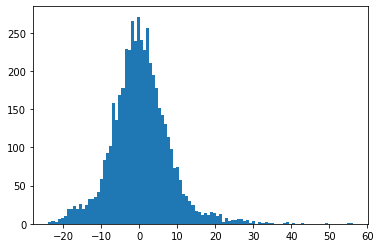

In [15]:
statistic(vn_dataset_df["sdrs_before"])

Nghe thử 1 audio chất lượng kém nhất

In [16]:
sample_detail(vn_dataset_df[vn_dataset_df["sdrs_before"] < -20].iloc[0])

clean_utterance_path           datasets/VinBigdata/dataset/47253/47253/vinfas...
embedding_utterance_path       datasets/VinBigdata/dataset/47253/47253/vinfas...
interference_utterance_path    datasets/ZaloAI2020/dataset/605/605-F-29/16k_6...
clean_segment                                                              16700
interference_segment                                                       32524
segment_length                                                                 3
sdrs_before                                                            -21.32385
sdrs_p                                                                -16.039722
sdrs_p_improve                                                          5.284128
sdrs_0                                                                -22.189928
sdrs_0_improve                                                         -0.866077
sdrs_t                                                                -20.679526
sdrs_t_improve              

Mixed audio


Target audio


Ref audio


Nghe thử 1 audio chất lượng trung bình

In [17]:
sample_detail(vn_dataset_df[(vn_dataset_df["sdrs_before"] < 0.5) & (vn_dataset_df["sdrs_before"] > -0.5)].iloc[0])

clean_utterance_path           datasets/VinBigdata/dataset/Anhdm_cr_712/Anhdm...
embedding_utterance_path       datasets/VinBigdata/dataset/Anhdm_cr_712/Anhdm...
interference_utterance_path    datasets/VinBigdata/dataset/Buithithe/Buithith...
clean_segment                                                              29756
interference_segment                                                        4228
segment_length                                                                 3
sdrs_before                                                             0.225123
sdrs_p                                                                  1.044181
sdrs_p_improve                                                          0.819057
sdrs_0                                                                 -6.931895
sdrs_0_improve                                                         -7.157019
sdrs_t                                                                 -5.226933
sdrs_t_improve              

Mixed audio


Target audio


Ref audio


Nghe thử 1 audio chất lượng tốt sẵn

In [18]:
sample_detail(vn_dataset_df[vn_dataset_df["sdrs_before"] > 10].iloc[0])

clean_utterance_path           datasets/ZaloAI2020/private-test/25/25/16k_qaj...
embedding_utterance_path       datasets/ZaloAI2020/private-test/25/25/16k_f7k...
interference_utterance_path    datasets/VinBigdata/dataset/50949/50949/vinfas...
clean_segment                                                               5586
interference_segment                                                        8462
segment_length                                                                 3
sdrs_before                                                             11.20986
sdrs_p                                                                 16.194977
sdrs_p_improve                                                          4.985118
sdrs_0                                                                  5.564764
sdrs_0_improve                                                         -5.645095
sdrs_t                                                                  3.942205
sdrs_t_improve              

Mixed audio


Target audio


Ref audio


Nghe thử 1 audio chất lượng quá tốt (outlier)

In [19]:
sample_detail(vn_dataset_df[vn_dataset_df["sdrs_before"] > 40].iloc[0])

clean_utterance_path           datasets/VinBigdata/dataset/Chinhnt_hw_2211/Ch...
embedding_utterance_path       datasets/VinBigdata/dataset/Chinhnt_hw_2211/Ch...
interference_utterance_path    datasets/VinBigdata/dataset/51760/51760/vinfas...
clean_segment                                                               4193
interference_segment                                                        6256
segment_length                                                                 3
sdrs_before                                                             42.86916
sdrs_p                                                                  7.705772
sdrs_p_improve                                                        -35.163388
sdrs_0                                                                  7.079034
sdrs_0_improve                                                        -35.790125
sdrs_t                                                                  7.036687
sdrs_t_improve              

Mixed audio


Target audio


Ref audio


Kết luận: [Input here]

## Đánh giá chất lượng của model sử dụng Power-law loss gốc

Mean:  4.6465124661655155
Median:  5.323562229038062


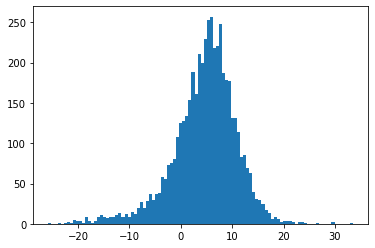

Mean:  4.283116190018083
Median:  4.881693957953818


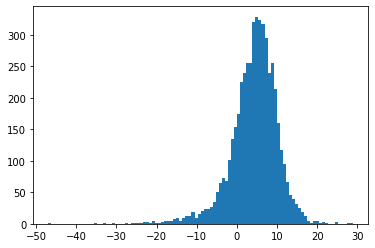

In [20]:
statistic(vn_dataset_df["sdrs_p"])
statistic(vn_dataset_df["sdrs_p_improve"])

## Đánh giá chất lượng của model sử dụng Power-law loss có fine-tune trên data Vin và tập train của ZaloAI

Mean:  6.696514192395481
Median:  7.0580367090429155


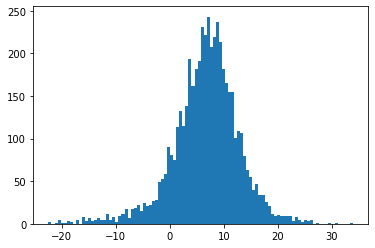

Mean:  6.333117916248049
Median:  6.541623681607258


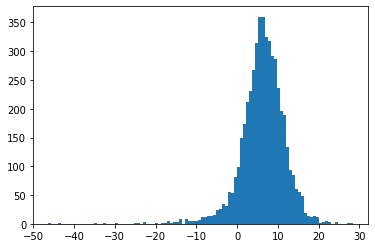

In [21]:
statistic(vn_dataset_df["sdrs_f"])
statistic(vn_dataset_df["sdrs_f_improve"])

## Đánh giá chất lượng của model sử dụng MSE loss gốc

Mean:  1.3758554749935248
Median:  1.9219184983587982


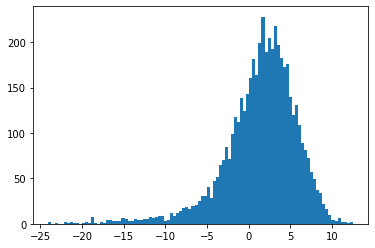

Mean:  1.0124591988460931
Median:  1.4841803250075938


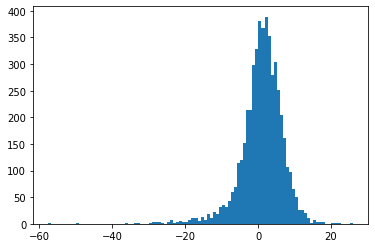

In [22]:
statistic(vn_dataset_df["sdrs_0"])
statistic(vn_dataset_df["sdrs_0_improve"])

## Đánh giá chất lượng của model sử dụng MSE loss gốc (c Tâm train)

Mean:  0.7400113019659924
Median:  1.4601902256031924


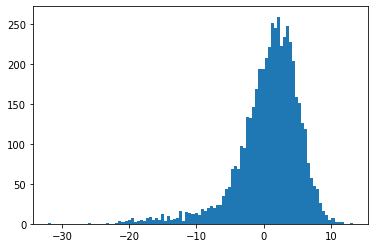

Mean:  0.37661502581856066
Median:  0.947353305097095


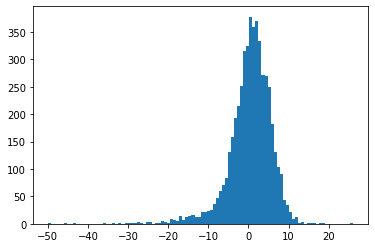

In [23]:
statistic(vn_dataset_df["sdrs_t"])
statistic(vn_dataset_df["sdrs_t_improve"])

## Nghe thử chất lượng audio inference của các model

In [24]:
low_sdr_samples = vn_dataset_df[vn_dataset_df["sdrs_before"] < -20]
low_sdr_samples

,clean_utterance_path,embedding_utterance_path,interference_utterance_path,clean_segment,interference_segment,segment_length,sdrs_before,sdrs_p,sdrs_p_improve,sdrs_0,sdrs_0_improve,sdrs_t,sdrs_t_improve,sdrs_f,sdrs_f_improve
17,datasets/VinBigdata/dataset/47253/47253/vinfas...,datasets/VinBigdata/dataset/47253/47253/vinfas...,datasets/ZaloAI2020/dataset/605/605-F-29/16k_6...,16700,32524,3,-21.323850,-16.039722,5.284128,-22.189928,-0.866077,-20.679526,0.644324,-21.996869,-0.673018
175,datasets/VinBigdata/dataset/54595/54595/vinfas...,datasets/VinBigdata/dataset/54595/54595/vinfas...,datasets/VinBigdata/dataset/Bon_in_2912/Bon_in...,491,26908,3,-20.356257,7.159572,27.515829,5.609586,25.965843,5.611245,25.967502,8.051772,28.408029
207,datasets/VinBigdata/dataset/52585/52585/vinfas...,datasets/VinBigdata/dataset/52585/52585/vinfas...,datasets/VinBigdata/dataset/Anhtrang00/Anhtran...,9265,1643,3,-22.721715,-18.298962,4.422753,-18.700901,4.020814,-19.772737,2.948977,-18.947655,3.774060
236,datasets/VinBigdata/dataset/51760/51760/vinfas...,datasets/VinBigdata/dataset/51760/51760/vinfas...,datasets/VinBigdata/dataset/Annp_hall_0312/Ann...,5643,371,3,-20.888192,-20.029479,0.858713,-18.597917,2.290275,-23.237895,-2.349703,-20.275008,0.613183
349,datasets/VinBigdata/dataset/440081/440081/vinf...,datasets/VinBigdata/dataset/440081/440081/vinf...,datasets/ZaloAI2020/dataset/466/466-F-31/16k_4...,69194,21655,3,-20.723254,-22.165602,-1.442348,-21.533635,-0.810381,-20.624568,0.098686,-19.973383,0.749871
1323,datasets/VinBigdata/dataset/52775/52775/vinfas...,datasets/VinBigdata/dataset/52775/52775/vinfas...,datasets/VinBigdata/dataset/44838/44838/vinfas...,14768,4066,3,-21.928206,-9.168115,12.760091,-14.918253,7.009953,-9.877410,12.050796,-15.952726,5.975480
1372,datasets/VinBigdata/dataset/54851/54851/vinfas...,datasets/VinBigdata/dataset/54851/54851/vinfas...,datasets/ZaloAI2020/dataset/752/752-M-37/16k_7...,4537,18563,3,-21.129182,-14.545249,6.583933,-15.915807,5.213375,-17.816946,3.312236,-13.290128,7.839054
2005,datasets/VinBigdata/dataset/54752/54752/vinfas...,datasets/VinBigdata/dataset/54752/54752/vinfas...,datasets/ZaloAI2020/dataset/481/481-M-31/16k_4...,3470,394,3,-20.271097,-13.947391,6.323706,-21.327249,-1.056152,-20.014347,0.256750,-9.307297,10.963800
2055,datasets/VinBigdata/dataset/54752/54752/vinfas...,datasets/VinBigdata/dataset/54752/54752/vinfas...,datasets/ZaloAI2020/dataset/89/89-F-26/16k_89-...,3622,4760,3,-21.250830,-10.010769,11.240062,-11.165472,10.085358,-19.759196,1.491634,-4.558515,16.692316
2752,datasets/VinBigdata/dataset/51670/51670/vinfas...,datasets/VinBigdata/dataset/51670/51670/vinfas...,datasets/ZaloAI2020/dataset/622/622-F-25/16k_6...,19157,13311,3,-20.408283,-20.046976,0.361307,-17.068838,3.339446,-20.409722,-0.001439,-15.778023,4.630260


In [25]:
inference_detail(low_sdr_samples.iloc[0], save=True)
pass

clean_utterance_path           datasets/VinBigdata/dataset/47253/47253/vinfas...
embedding_utterance_path       datasets/VinBigdata/dataset/47253/47253/vinfas...
interference_utterance_path    datasets/ZaloAI2020/dataset/605/605-F-29/16k_6...
clean_segment                                                              16700
interference_segment                                                       32524
segment_length                                                                 3
sdrs_before                                                            -21.32385
sdrs_p                                                                -16.039722
sdrs_p_improve                                                          5.284128
sdrs_0                                                                -22.189928
sdrs_0_improve                                                         -0.866077
sdrs_t                                                                -20.679526
sdrs_t_improve              

Mixed audio


Target audio


Ref audio


Power-law predict


Power-law fine-tune predict


MSE predict


MSE ms.T predict


In [26]:
inference_detail(low_sdr_samples.iloc[1], save=True)
pass

clean_utterance_path           datasets/VinBigdata/dataset/54595/54595/vinfas...
embedding_utterance_path       datasets/VinBigdata/dataset/54595/54595/vinfas...
interference_utterance_path    datasets/VinBigdata/dataset/Bon_in_2912/Bon_in...
clean_segment                                                                491
interference_segment                                                       26908
segment_length                                                                 3
sdrs_before                                                           -20.356257
sdrs_p                                                                  7.159572
sdrs_p_improve                                                         27.515829
sdrs_0                                                                  5.609586
sdrs_0_improve                                                         25.965843
sdrs_t                                                                  5.611245
sdrs_t_improve              

Mixed audio


Target audio


Ref audio


Power-law predict


Power-law fine-tune predict


MSE predict


MSE ms.T predict


In [ ]:
inference_detail(low_sdr_samples.iloc[5], save=True)
pass

clean_utterance_path           datasets/VinBigdata/dataset/52775/52775/vinfas...
embedding_utterance_path       datasets/VinBigdata/dataset/52775/52775/vinfas...
interference_utterance_path    datasets/VinBigdata/dataset/44838/44838/vinfas...
clean_segment                                                              14768
interference_segment                                                        4066
segment_length                                                                 3
sdrs_before                                                           -21.928206
sdrs_p                                                                 -9.168115
sdrs_p_improve                                                         12.760091
sdrs_0                                                                -14.918253
sdrs_0_improve                                                          7.009953
sdrs_t                                                                  -9.87741
sdrs_t_improve              

Mixed audio


Target audio


Ref audio


Power-law predict


Power-law fine-tune predict


In [ ]:
inference_detail(low_sdr_samples.iloc[-2], save=True)
pass

In [ ]:
abnormal_sdr_samples = vn_dataset_df[vn_dataset_df["sdrs_before"] > 40]
abnormal_sdr_samples

In [ ]:
inference_detail(abnormal_sdr_samples.iloc[-1], save=True)
pass

In [ ]:
inference_detail(abnormal_sdr_samples.iloc[2], save=True)
pass

In [ ]:
p_best_improve_samples = vn_dataset_df[vn_dataset_df["sdrs_p_improve"] > 25]
p_best_improve_samples

In [ ]:
inference_detail(p_best_improve_samples.iloc[1], save=True)
pass

In [ ]:
p_worse_improve_samples = vn_dataset_df[vn_dataset_df["sdrs_p_improve"] < -40]
p_worse_improve_samples

In [ ]:
inference_detail(p_worse_improve_samples.iloc[0], save=True)
pass